# **Statistika Bayesian**

Statistika Bayesian adalah pendekatan dalam inferensi statistik yang didasarkan pada Teorema Bayes. Berbeda dengan statistik klasik (frekuentis), pendekatan Bayesian secara eksplisit memperlakukan parameter sebagai variabel acak dan memperbarui kepercayaan terhadap parameter berdasarkan data yang diamati.

$$
P(\theta \mid D) = \frac{P(D \mid \theta) \cdot P(\theta)}{P(D)}

| Komponen           | Arti                                                                      |
| ------------------ | ------------------------------------------------------------------------- |
| $\theta$           | Parameter yang ingin diestimasi                                           |
| $D$                | Data yang diamati                                                         |
| $P(\theta)$        | **Prior**: Kepercayaan awal terhadap nilai parameter sebelum melihat data |
| $P(D \mid \theta)$ | **Likelihood**: Kemungkinan data terjadi jika parameter bernilai $\theta$ |
| $P(\theta \mid D)$ | **Posterior**: Distribusi parameter setelah melihat data                  |
| $P(D)$             | Evidence: Normalisasi agar hasilnya berupa distribusi probabilitas        |


In [1]:
import pandas as pd
import copy

import bambi as bmb
print(f'Bambi version : {bmb.__version__}')
import arviz as az
print(f'Arviz version : {bmb.__version__}')

import seaborn as sns
sns.set(style="whitegrid")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Bambi version : 0.13.0
Arviz version : 0.13.0


In [2]:
# Load data
df = sns.load_dataset("iris")
df['species'].unique()  

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [3]:
# Bayesian Model 
model = bmb.Model("sepal_length ~ species", data=df, family='gaussian')
print(model)

       Formula: sepal_length ~ species
        Family: gaussian
          Link: mu = identity
  Observations: 150
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 5.843333333333334, sigma: 2.917880699716453)
            species ~ Normal(mu: [0. 0.], sigma: [4.37682105 4.37682105])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8253012917851409)


In [4]:
results = model.fit(chains=4, draws=1000, tune=1000, random_seed=38, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sepal_length_sigma, Intercept, species]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.


In [5]:
results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [6]:
# Copy results agar aman
results_2 = copy.deepcopy(results)  

Alasan mengapa setosa tidak ada dibawah adalah karena dia yg dibandingkan dengan lainnya

```python
# Mengatur Siapa yang menjadi pembanding
df['species'] = pd.Categorical(
    df['species'], 
    # categories yg awal sebagai pembanding
    categories=['virginica', 'setosa', 'versicolor']
)

In [7]:
# Ringkasan hasil
az.summary(results, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,5.007,0.074,4.856,5.148,0.001,0.001,3561.0,3112.0,1.0
species[versicolor],0.928,0.102,0.734,1.139,0.002,0.001,2765.0,3031.0,1.0
species[virginica],1.581,0.104,1.373,1.780,0.002,0.001,3495.0,3052.0,1.0
sepal_length_sigma,0.518,0.030,0.459,0.576,0.000,0.000,4282.0,3192.0,1.0


| Hasil                | Mean  | HDI 95%         | Interpretasi                                                        |
| ------------------------- | ----- | --------------- | ------------------------------------------------------------------- |
| **Intercept**             | 5.007 | \[4.856, 5.148] | Rata-rata panjang sepal untuk **setosa** (baseline reference group) |
| `species[versicolor]`     | 0.928 | \[0.734, 1.139] | Versicolor memiliki **rata-rata 0.93 cm lebih panjang** dari setosa |
| `species[virginica]`      | 1.581 | \[1.373, 1.780] | Virginica memiliki **rata-rata 1.58 cm lebih panjang** dari setosa  |
| `sepal_length_sigma`      | 0.518 | \[0.459, 0.576] | Deviasi standar residual (error) model                              |
| `r_hat` seluruh parameter | 1.0   |                 | Konvergensi sempurna (model stabil dan valid)                       |


## **Plot Interpretasi Hasil**

> **Plot HDI**

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

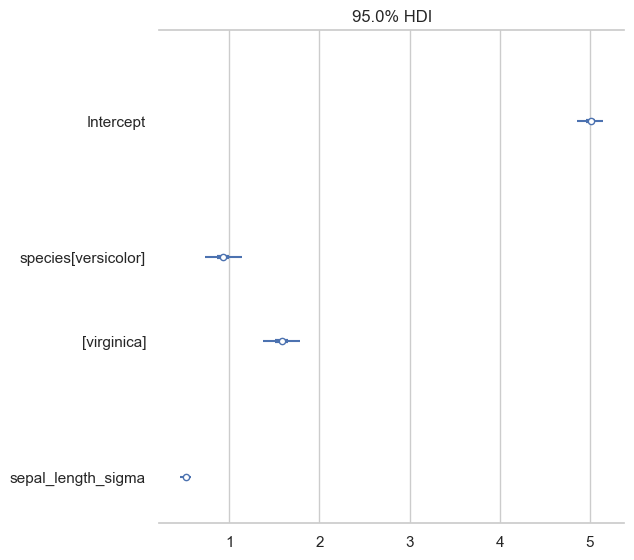

In [8]:
# Plot distribusi posterior dari koefisien (efek antar grup)
az.plot_forest(results, combined=True, hdi_prob=0.95)

> **Plot Prior dan posterior**

- **Prior** : pengetahuan atau keyakinan awal tentang parameter sebelum kita melihat data.
- **Posterior** : keyakinan baru setelah mempertimbangkan data dan prior

array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'species\nversicolor'}>,
       <Axes: title={'center': 'species\nvirginica'}>,
       <Axes: title={'center': 'sepal_length_sigma'}>], dtype=object)

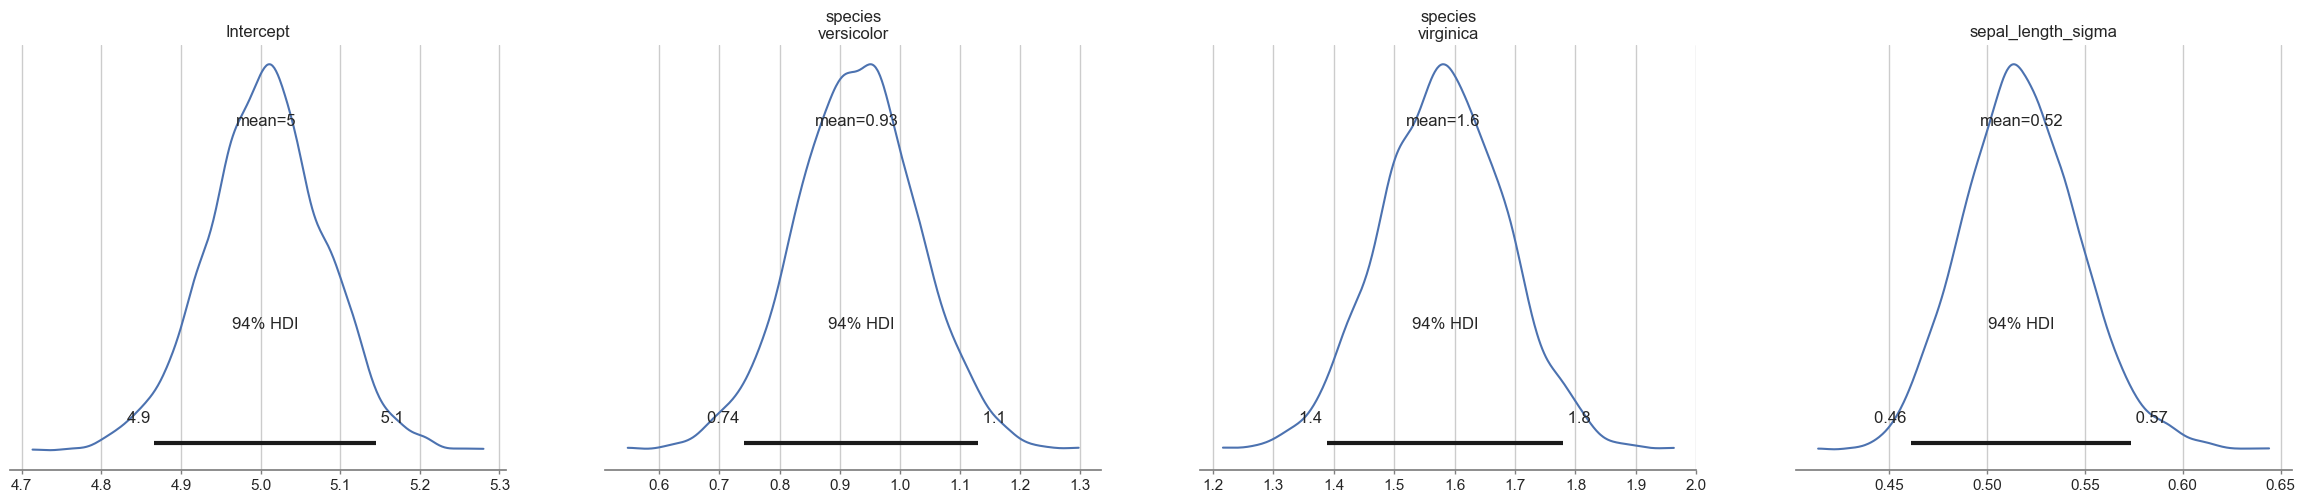

In [9]:
az.plot_posterior(results)

In [10]:
idata_prior = model.prior_predictive(draws=1000, random_seed=38)
idata_prior

Sampling: [Intercept, sepal_length, sepal_length_sigma, species]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

**Bayesian Factor :** salah satu metode pembanding model atau hipotesis dalam kerangka statistik Bayesian. Ia memberikan cara untuk mengkuantifikasi seberapa besar bukti dalam data mendukung satu hipotesis dibandingkan dengan hipotesis lainnya, dengan mempertimbangkan informasi prior dan data yang diamati.

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\data\base.py:272: UserWarning: More chains (3) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
arviz - WARNING - The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.
arviz - WARNING - Posterior distribution has {posterior.ndim} dimensions


(0.0, 1.55)

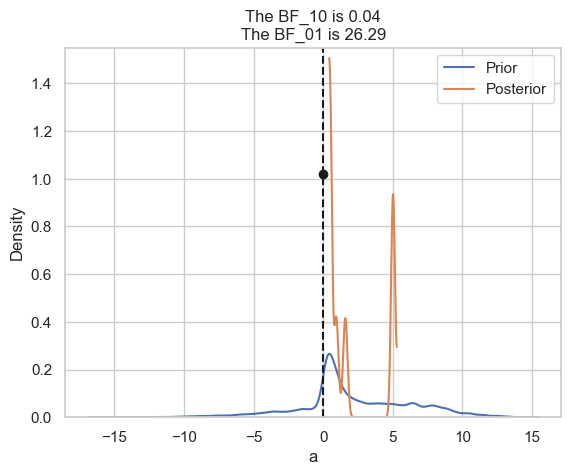

In [11]:
idata_bf = az.from_dict(
    prior={'a' : idata_prior.prior.to_dataarray()},
    posterior={'a' : results.posterior.to_dataarray()}
)
fig, ax = az.plot_bf(idata_bf, var_name='a', ref_val=0)
ax.set_ylim(0, 1.55)

> **Plot Posterior Predictive Check (PPC)**

mengevaluasi kecocokan model Bayesian, khususnya dengan membandingkan prediksi dari posterior dengan data yang sebenarnya diamati.

Jika garis hitam mirip dengan garis oren maka model mampu menangkap pola data dengan baik

In [12]:
# Wajib dilakukan untuk menambah posterior_predictive
# Jika ditambah diawal maka plot lain akan kacau, maka dari itu digunakan di results_2
model.predict(idata=results_2, kind="pps", inplace=True)
results_2

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

<Axes: xlabel='sepal_length'>

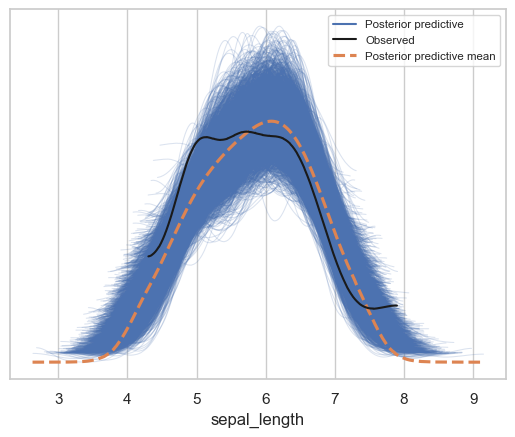

In [13]:
az.plot_ppc(results_2)

<Axes: xlabel='sepal_length'>

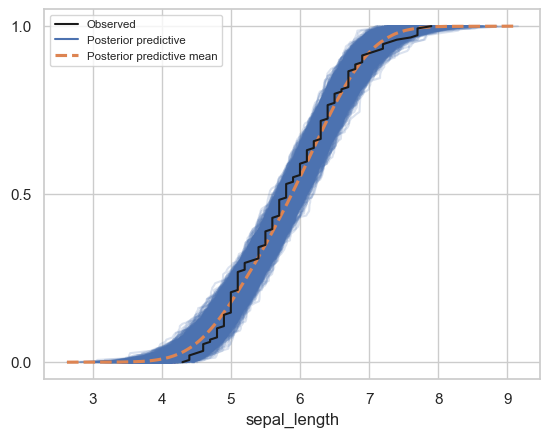

In [14]:
az.plot_ppc(results_2, kind='cumulative')

> **Plot Bayesian P-Value**

posterior predictive checks (PPC) berbasis statistik ringkasan (misal mean, median), dengan tujuan menguji seberapa baik model Bayesian kita merepresentasikan data sebenarnya.

| Jenis     | Penjelasan Singkat                                                                                                  | Tujuan                                                                             | Interpretasi                                          |
| --------- | ------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- | ----------------------------------------------------- |
| `p_value` | Menggunakan statistik ringkasan (mean, median, dsb) antara data sebenarnya dan data prediksi                        | Cek apakah statistik dari data observasi berada di dalam distribusi prediksi model | Bandingkan antara garis data aktual vs prediksi       |
| `u_value` | Menggunakan empirical cumulative distribution function (ECDF) u-value (probabilitas kumulatif posterior predictive) | Melihat kesesuaian keseluruhan distribusi                                          | Apakah distribusi prediksi terlalu ekstrem atau tidak |


<Axes: title={'center': 'sepal_length'}>

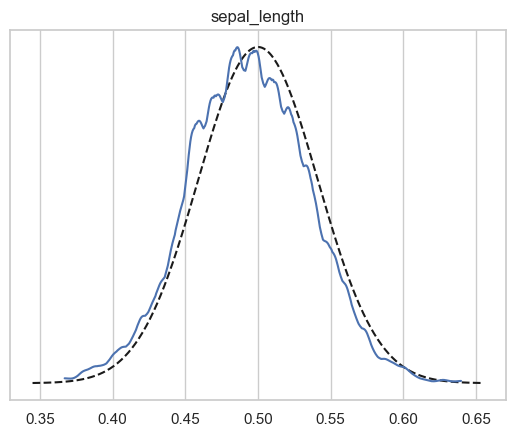

In [15]:
az.plot_bpv(results_2, t_stat="mean", kind='p_value')

<Axes: title={'center': 'sepal_length'}>

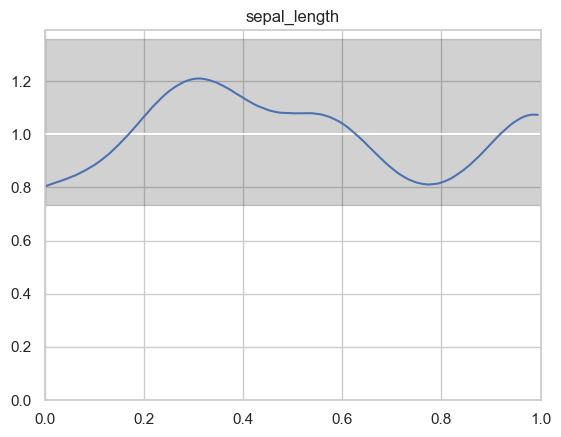

In [16]:
az.plot_bpv(results_2, t_stat="mean", kind='u_value')

kurva biru berada dalam area abu-abu dan mendekati garis horizontal 1, distribusi model cocok dengan data.

> **Plot Evaluation Traning**

Trace plot dan autocorrelation plot digunakan untuk mengevaluasi hasil pelatihan model Bayesian, khususnya saat menggunakan algoritma sampling seperti MCMC (Markov Chain Monte Carlo).

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'species'}>,
        <Axes: title={'center': 'species'}>],
       [<Axes: title={'center': 'sepal_length_sigma'}>,
        <Axes: title={'center': 'sepal_length_sigma'}>]], dtype=object)

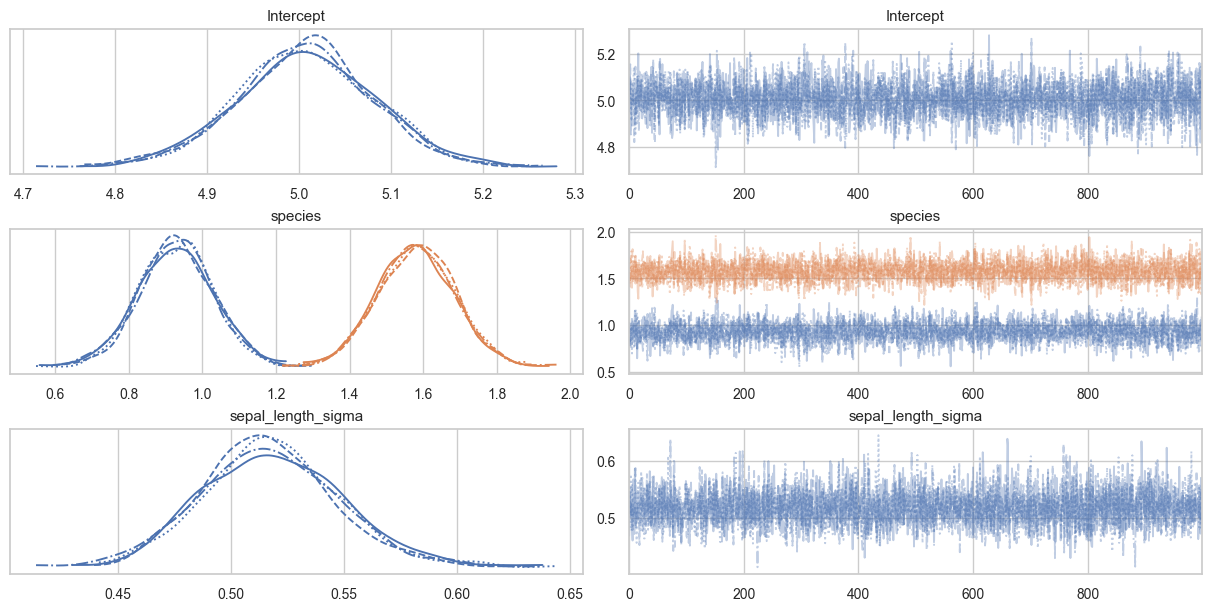

In [17]:
az.plot_trace(
    results,
    figsize=(12, 6),         # Ukuran figure lebih lebar
    compact=True,            # Gabungkan chains dalam satu plot
    combined=False,          # False jika ingin tetap tampil per-chain
    backend_kwargs={"layout": "constrained"},  # Atur layout otomatis
)

> **Plot Compare**

In [18]:
model = bmb.Model("sepal_length ~ species", data=df, family='gaussian')
print('Model Full : \n', model, f'\n{'_' * 100}\n')

model2 = bmb.Model("sepal_length ~ 1", data=df, family='gaussian')
print('Model Null : \n', model2)

Model Full : 
        Formula: sepal_length ~ species
        Family: gaussian
          Link: mu = identity
  Observations: 150
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 5.843333333333334, sigma: 2.917880699716453)
            species ~ Normal(mu: [0. 0.], sigma: [4.37682105 4.37682105])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8253012917851409) 
____________________________________________________________________________________________________

Model Null : 
        Formula: sepal_length ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 150
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 5.843333333333334, sigma: 2.0632532294628523)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8253012917851409)


In [19]:
results2 = model2.fit(chains=4, draws=1000, tune=1000, random_seed=38, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sepal_length_sigma, Intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


In [20]:
results2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

| Method            | Penjelasan                                                                                                                                                                |
| ----------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `"BB-pseudo-BMA"` | Bayesian Bootstrap Pseudo-Bayesian Model Averaging. Menggunakan *Bayesian bootstrap* untuk menghitung bobot model berdasarkan LOO. Lebih robust terhadap ketidakpastian.  |
| `"pseudo-BMA"`    | Pseudo Bayesian Model Averaging. Menggunakan skor informasi (LOO atau WAIC) untuk menghitung bobot model tanpa mempertimbangkan ketidakpastian (tanpa bootstrap).         |
| `"stacking"`      | Metode **stacking of predictive distributions**. Mencari kombinasi model dengan performa prediktif terbaik di masa depan. Lebih direkomendasikan untuk *model averaging*. |


| IC       | Penjelasan                                                                                                                                     |
| -------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| `"loo"`  | **Leave-One-Out Cross-Validation**: Menghitung kinerja prediktif dengan meninggalkan satu data setiap kali. Lebih stabil untuk model Bayesian. |
| `"waic"` | **Widely Applicable Information Criterion**: Alternatif LOO, menghitung kompleksitas efektif model dan penalti overfitting.                    |
| `"aic"`  | Akaike Information Criterion (untuk model non-Bayesian).                                                                                       |
| `"bic"`  | Bayesian Information Criterion (juga untuk model klasik). Tidak cocok untuk model dari `bambi` atau `PyMC`.                                    |


In [21]:
compare_dict = {"model_full": results, "model_null": results2}
comp_df = az.compare(compare_dict, method="BB-pseudo-BMA", ic="loo")
comp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_full,0,-115.941761,4.158012,0.000000,1.000000e+00,9.559029,0.000000,False,log
model_null,1,-185.891085,1.688292,69.949324,3.178880e-14,7.334159,8.551632,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

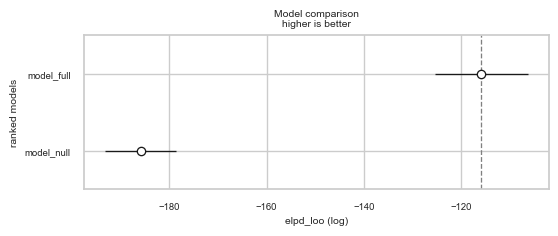

In [22]:
az.plot_compare(comp_df)

| Komponen                          | Interpretasi                                                                                                                         |
| --------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| **model\_full**                   | Terletak paling kanan (mendekati 0), artinya memiliki nilai `elpd_loo` tertinggi → ini model terbaik.                                |
| **model\_null**                   | Nilai `elpd_loo` lebih rendah dan jauh di kiri → model ini jauh lebih buruk dalam memprediksi.                                       |
| **Jarak antar titik + error bar** | Tidak ada overlap antara error bar `model_full` dan `model_null` → artinya **perbedaan performa model signifikan** secara statistik. |
